# Preamble

In [445]:
import numpy as np
import pandas as pd
from pylab import meshgrid
from scipy import exp,optimize,log,floor
from scipy.signal import argrelextrema
from scipy.optimize import fsolve
from scipy.integrate import ode
backend = 'dopri5'

# Timer
import time

# To store data
import pickle

# Plotting
%matplotlib inline

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker

# Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': True, 'font.serif': "cm", 'font.family': 'DejaVu Sans', 
            'text.latex.preamble': r"\usepackage{type1cm}"})

# some shapes
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

clrs = sns.color_palette("colorblind",8) 
lwd = 2 # line width by default

# Heaviside function #
Heaviside = lambda x: 1 * (x >= 0)
# Cut function #
cut_func = lambda x: 1. if x > 1. else x

# to show PDFs in the notebook
from wand.image import Image as WImage

import warnings
warnings.filterwarnings("ignore")

import sys
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


# Parameters values

### Main pathway dynamics

In [446]:
α = 0.3; θ = 0.45
κ = 40.0 # Robustness parameter for the main pathway

Reduction and translocation factors to the expression of the main pathway due to the treatment

In [447]:
A = lambda σ: 1-σ*(1-θ)

Production function as a step-like function and corresponding potential function

In [448]:
f = lambda y, σ: A(σ)*(α+(1-α)*Heaviside(y-θ))
U = lambda y, σ: -A(σ)*(α+(1-α)*Heaviside(y-θ))*(y-θ)+(y**2-θ**2)/2

Corresponding potential bariers (will be required for the dynamics)

In [449]:
Eplus = lambda σ: U(θ,σ)-U(f(1.,σ),σ)
Eminus = lambda σ: U(θ,σ)-U(f(0.,σ),σ)

Difference in potential bariers

In [450]:
ΔE = lambda σ: Eplus(σ)-Eminus(σ)

### Fitting some parameter values according with Bozic, Reiter et al 2013 *eLife*

In [451]:
d = 0.13 # death rate per day

In [452]:
b = (0.1*(exp(κ*ΔE(1))+1)-0.14*(exp(κ*ΔE(0))+1))/(exp(κ*ΔE(1))-exp(κ*ΔE(0)))
χ = 1-(0.14*(exp(κ*ΔE(0))+1)-b*exp(κ*ΔE(0)))/b
print("Birth rate: %.4f" % b)
print("Penalty χ: %.4f" % χ)

Birth rate: 0.1402
Penalty χ: 0.3260


### Other parameters

In [453]:
c = 0.1*(b*(1-χ/(exp(κ*ΔE(0))+1))-d)/b # cost of resistance
μ = (2/34)*(exp(κ*ΔE(1))+1) # transition rate from sensitive (down-regulated main pathway) to resistant cell-type
μbar = (μ/3)*exp(κ*Eminus(0)) # inversed transition rate from resistant (down-regulated alternative pathway) to sensitive cell-type
ε = 0.01 # initial fraction of resistant cells

print("Time for direct transition: %.4f" % (1/μ))
print("Time for reverse transition: %.4f" % (1/μbar))
print("Cost of resistance: %.1f%%" % (c*100))

Time for direct transition: 14.9457
Time for reverse transition: 28.5894
Cost of resistance: 0.7%


# Figure 1

All parts of Figure 1 were assembled in external program Adobe Illustrator (licence of Hokkaido University).

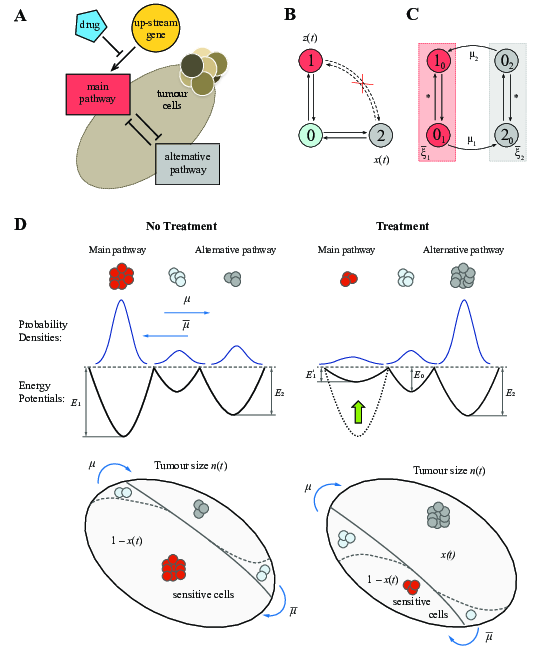

In [454]:
WImage(filename='../figures/Fig1.pdf')

# Figure S1
## (A) Step-like functions for pathway activity

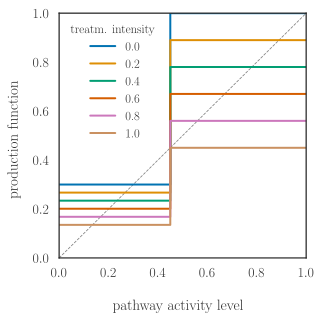

In [455]:
plt.rcParams['figure.figsize'] = (4.75, 4.75)

fig, ax = plt.subplots()
ax.margins(0.0)

σs = np.arange(0,1.2,.2)
clrs = sns.color_palette("colorblind",len(σs))
plt.plot([0,1],[0,1],lw=.8,ls="--",color="gray")

for i in range(len(σs)):
    σ = σs[i]
    plt.plot([0,θ,θ,1],[f(0,σ),f(0,σ),f(1,σ),f(1,σ)],color=clrs[i],lw=lwd,label="%.1f"%σ);
    
plt.xlabel('pathway activity level',labelpad=20);
plt.ylabel('production function',labelpad=12);

legend = plt.legend(loc=2,ncol=1,frameon=1,title='treatm. intensity',fontsize='small');
plt.setp(legend.get_title(),fontsize='small')
legend.draw_frame(False)

plt.tight_layout()
plt.savefig("../figures/draft/FigS1-A.pdf",format='pdf',bbox_inches='tight')

## (B) Potential function

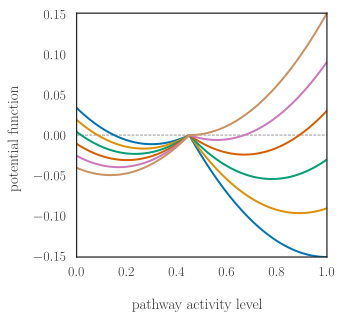

In [456]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

fig, ax = plt.subplots()
ax.margins(0.0)

plt.plot([0,1],[0,0],lw=.8,ls="--",color="gray")
for i in range(len(σs)):
    σ = σs[i]
    yi = np.concatenate([np.linspace(0.,θ,40),np.linspace(θ,1.,40)])
    plt.plot(yi,U(yi,σ),color=clrs[i],lw=2,label=σ);
        
plt.xlabel('pathway activity level',labelpad=20);
plt.ylabel('potential function',labelpad=12);

plt.savefig("../figures/draft/FigS1-B.pdf",format='pdf',bbox_inches='tight')

In [457]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}

\begin{document}
\begin{tikzpicture}
    \node[anchor=north east] {\includegraphics[width=2.95in]{../figures/draft/FigS1-A.pdf}};
    \node[anchor=north west] at (.1in,0in) {\includegraphics[width=3.1in]{../figures/draft/FigS1-B.pdf}};
    \node[anchor=south east] at (-2.85in,-.04in) {\large {\bf A}};
    \node[anchor=south west] at (.06in,-.04in) {\large {\bf B}};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/FigS1.pdf
rm texput.*

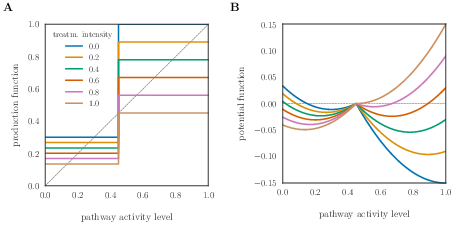

In [458]:
# Final result
WImage(filename='../figures/FigS1.pdf')

# Dynamical equations

We have the following dynamics to describe the relative frequency $x$ of drug-tolerant cells:

$$\frac{\mathrm dn(t)}{\mathrm dt} = b\left(1-\frac{\chi(1-x(t))}{e^{\kappa\Delta E}+1}-cx(t)\right)n(t)-dn(t)\,,$$

$$\frac{\mathrm dx(t)}{\mathrm dt} = b\left(\frac\chi{e^{\kappa\Delta E}+1}-c\right)x(t)(1-x(t))+\frac{\mu(1-x(t))}{e^{\kappa\Delta E}+1}-\bar\mu e^{-\kappa E^{-}}x(t)\,.$$

Dynamics incorporated in Python:

In [459]:
# X = (X[1],X[2]) = (x,n)
ode_rhs = lambda t, X, σ: [b*(χ/(exp(κ*ΔE(σ))+1)-c)*X[0]*(1-X[0])+μ*(1-X[0])/(exp(κ*ΔE(σ))+1)-μbar*exp(-κ*Eminus(σ))*X[0],\
            b*(1-χ*(1-X[0])/(exp(κ*ΔE(σ))+1)-c*X[0])*X[1]-d*X[1]]

# Only to track the dynamics of x (relative fraction of resistant cells)
ode_rhs_only_x = lambda t, x, σ: b*(χ/(exp(κ*ΔE(σ))+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE(σ))+1)-μbar*exp(-κ*Eminus(σ))*x

## Figure S2

Let's look how $\Delta E$, $\frac{\chi}{e^{\kappa \Delta E}+1}$ and $e^{-\kappa E^{-}}$ depend on $\sigma$

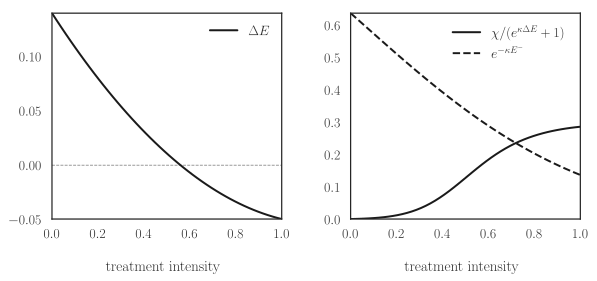

In [461]:
plt.rcParams['figure.figsize'] = (9.5, 3.8)

ax = plt.subplot(121)
plt.subplots_adjust(wspace = 0.3)

plt.plot([0,1],[0,0],lw=.8,ls="--",color="gray")

σi = np.linspace(0.,1.,50);
plt.plot(σi,ΔE(σi),color="k",lw=2,label=r'$\Delta E$');

plt.xlabel('treatment intensity',labelpad=20);
plt.legend(loc=1,frameon=0);

plt.margins(0.0)
ax.yaxis.set_major_locator(plticker.MultipleLocator(.05))

ax = plt.subplot(122)
 
plt.plot(σi,χ/(exp(κ*ΔE(σi))+1.),color="k",lw=2,label=r'${\chi}/{(e^{\kappa\Delta E}+1)}$');
plt.plot(σi,exp(-κ*Eminus(σi)),color="k",lw=2,ls='--',label=r'$e^{-\kappa E^{-}}$');

plt.xlabel('treatment intensity',labelpad=20);
legend = plt.legend(loc=1,frameon=0,ncol=1)

plt.margins(0.0)
ax.yaxis.set_major_locator(plticker.MultipleLocator(.1))

plt.savefig("../figures/FigS2.pdf",format='pdf',bbox_inches='tight')

# Figure S3

Best outcome: 2.38 months at σ = 0.67
MTD gives the relapse in 2.12 months


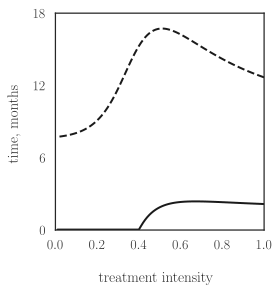

In [496]:
plt.rcParams['figure.figsize'] = (3.75, 4)

def func_threshold(τ,ε,σ,threshold):
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.]).set_f_params(σ)
    solver.integrate(τ)
    return solver.y[1]-threshold

σi = [1.]; δσ = .01
t_sol = 450.; t_sol10 = 600.; t_thr = []; t_thr10 = []
while σi[-1]>=0: 
    t_sol = fsolve(func_threshold,t_sol,args=(ε,σi[-1],1.))[0]; t_thr += [t_sol]
    t_sol10 = fsolve(func_threshold,t_sol10,args=(ε,σi[-1],10.))[0]; t_thr10 += [t_sol10]
    σi += [σi[-1]-δσ]
σi = σi[:-1]
plt.plot(σi,[x+1 for x in t_thr],color="k",lw=lwd,ls='-')
plt.plot(σi,[x+1 for x in t_thr10],color="k",lw=lwd,ls='--')

imx = np.argmax(t_thr)
print("Best outcome: %.2f months at σ = %.2f" % ((1+t_thr[imx])/30,σi[imx]))

print("MTD gives the relapse in %.2f months" % (t_thr[0]/30))

plt.xlabel('treatment intensity',labelpad=20);
plt.ylabel('time, months',labelpad=12)
plt.xlim([0,1]) 
plt.ylim([0,12*30])
plt.xticks(np.arange(0,1.2,.2))
plt.yticks(np.arange(0,24*30,180),np.arange(0,24,6))
plt.margins(0.0)

plt.savefig("../figures/draft/FigS3-A.pdf",format='pdf',bbox_inches='tight')

In [684]:
def func_sol(τ,ε,σ):
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.]).set_f_params(σ)
    solver.integrate(τ)
    return solver.y[1]

σi = [1.]; δσ = .025
tmins = []; reduction = []
while σi[-1]>=0: 
    τs = np.linspace(0,80,200+1)
    sol = [func_sol(τ,ε,σi[-1]) for τ in τs]
    index_min = np.argmin(sol)
    tmins += [τs[index_min]]
    reduction += [1-sol[index_min]]
    σi += [σi[-1]-δσ]
σi = σi[:-1]

Reduction for MTD (sigma = 1.00): 21.4%


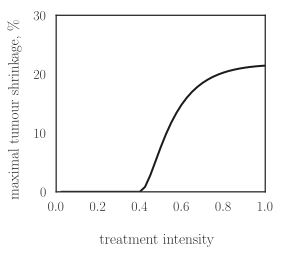

In [689]:
plt.rcParams['figure.figsize'] = (3.75, 3.25)

plt.plot(σi,[100*x for x in reduction],color="k",lw=lwd,ls='-')

print("Reduction for MTD (sigma = %.2f): %.1f%%"%(σi[0],100*reduction[0]))

plt.xlabel('treatment intensity',labelpad=20);
plt.ylabel(r'maximal tumour shrinkage, \%',labelpad=12)
plt.xticks(np.arange(0,1.2,.2)), plt.yticks(np.arange(0,60,10))
plt.xlim([0,1]), plt.ylim([0,30])
plt.margins(0.0)

plt.savefig("../figures/draft/FigS3-B.pdf",format='pdf',bbox_inches='tight')

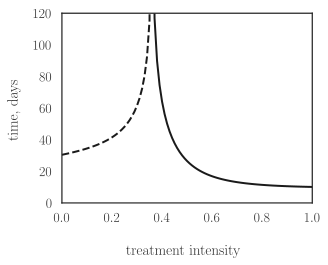

In [499]:
plt.rcParams['figure.figsize'] = (4.5, 3.5)

def func_fifty(τ,ε,σ):
    solver = ode(ode_rhs_only_x).set_integrator(backend)
    solver.set_initial_value([ε]).set_f_params(σ)
    solver.integrate(τ)
    return solver.y[0]-.5

σi = [1.];
δσ = .01
t_sol = 50.; t_fifty = [];
while t_sol <= tmax:
    t_sol = fsolve(func_fifty,t_sol,args=(ε,σi[-1]))[0]
    t_fifty += [t_sol]
    σi += [σi[-1]-δσ]
σi = σi[:-1]
plt.plot(σi,t_fifty,color="k",lw=lwd,ls='-')

# in reverse direction: from 99% resistance toward 50%
σi = [.0];
t_sol = 50.; t_fifty = [];
while t_sol <= tmax:
    t_sol = fsolve(func_fifty,t_sol,args=(1-ε,σi[-1]))[0]
    t_fifty += [t_sol]
    σi += [σi[-1]+δσ]
σi = σi[:-1]
plt.plot(σi,t_fifty,color="k",lw=lwd,ls='--')

plt.xlabel('treatment intensity',labelpad=20);
plt.ylabel('time, days',labelpad=12)
plt.xlim([0,1]), plt.ylim([0,120])
plt.xticks(np.arange(0,1.2,.2))#, plt.yticks(np.arange(0,tmax/2+60,60))
plt.margins(0.0)

plt.savefig("../figures/draft/FigS3-C.pdf",format='pdf',bbox_inches='tight')

(**Caption**) Time necessary to acquire 50%-level of resistance starting from initial 1% (solid) *vs* time necessary to lower the resistance level from 99% to 50% (dashed).

In [521]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}

\begin{document}
\begin{tikzpicture}
    \node[anchor=north east] {\includegraphics[width=2.95in]{../figures/draft/FigS3-A.pdf}};
    \node[anchor=north west] at (.1in,-.125in) {\includegraphics[width=3.1in]{../figures/draft/FigS3-B.pdf}};
    \node[anchor=north west] at (-1.6in,-3.3in) {\includegraphics[width=3.1in]{../figures/draft/FigS3-C.pdf}};
    \node[anchor=south east] at (-2.85in,-.04in) {\large {\bf A}};
    \node[anchor=south west] at (.06in,-.04in) {\large {\bf B}};
    \node[anchor=south west] at (-1.65in,-3.4in) {\large {\bf C}};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/FigS3.pdf
rm texput.*

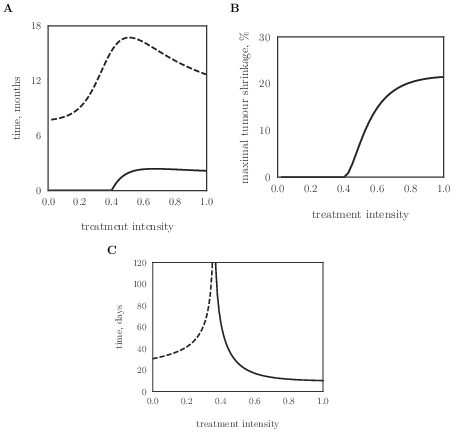

In [522]:
# Final result
WImage(filename='../figures/FigS3.pdf')

# Figure 4: Comparing static & periodic treatment

Static treatment
σ = 0.0 leads to 3.32-fold change after 120 days (final resistance level = 1.1%)
σ = 0.1 leads to 3.15-fold change after 120 days (final resistance level = 3.8%)
σ = 0.2 leads to 2.76-fold change after 120 days (final resistance level = 12.1%)
σ = 0.3 leads to 2.13-fold change after 120 days (final resistance level = 31.3%)
σ = 0.4 leads to 1.59-fold change after 120 days (final resistance level = 58.0%)
σ = 0.5 leads to 1.37-fold change after 120 days (final resistance level = 76.5%)
Periodic treatment
σ = 0.0 leads to 3.32-fold change after 120 days (final resistance level = 1.1%)
σ = 0.2 leads to 2.99-fold change after 120 days (final resistance level = 6.5%)
σ = 0.4 leads to 1.98-fold change after 120 days (final resistance level = 32.9%)
σ = 0.6 leads to 1.36-fold change after 120 days (final resistance level = 63.9%)
σ = 0.8 leads to 1.25-fold change after 120 days (final resistance level = 75.4%)
σ = 1.0 leads to 1.25-fold change after 120 days (final resistance

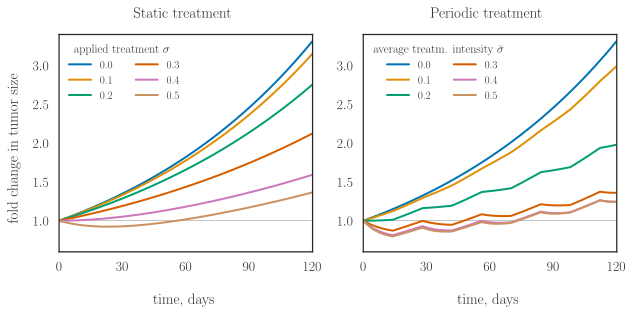

In [528]:
ymx = 3.4
ymn = .6

plt.rcParams['figure.figsize'] = (10, 4)
gs = gridspec.GridSpec(1,2,width_ratios=[1,1]) 
plt.subplot(gs[0])
plt.subplots_adjust(wspace = 0.2)
        
print("Static treatment")
_i = 0
for σ in σs:
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.]).set_f_params(.5*σ)
    sol = []; _k = 0;
    while solver.t < max(ti):
        solver.integrate(ti[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    plt.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[_i],lw=2,label="%.1f"%(.5*σ));
    print("σ = %.1f leads to %.2f-fold change after %d days (final resistance level = %.1f%%)" % 
      (.5*σ,sol[-1][2],sol[-1][0],sol[-1][1]*1e2))
    _i += 1;
    
plt.plot([0,max(ti)],[1]*2,lw=.5,ls="-",color="gray",zorder=-2)

plt.xlabel('time, days',labelpad=20);
plt.ylabel('fold change in tumor size',labelpad=12);
# plt.yscale('log')
plt.xlim([0,tmax])
plt.ylim([ymn,ymx])
# ytks = [1,10,1e2,1e3]; plt.yticks(ytks)
plt.xticks(np.arange(0,tmax+30,30))
legend = plt.legend(ncol=2,frameon=0,title=r'applied treatment $\sigma$',loc=2,fontsize=11);
plt.setp(legend.get_title(),fontsize=12)
plt.title('Static treatment', y=1.05)
plt.margins(0.0)

plt.subplot(gs[1])
        
print("Periodic treatment")
treatment_periodicity = 14 # in days
_i = 0
for σ in σs:
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.])
    sol = []; _k = 0;
    tme = 0; treatment = True
    while (solver.t < max(ti)):
        while (tme+treatment_periodicity < ti[_k]):
            tme += treatment_periodicity
            solver.set_f_params(int(treatment)*σ).integrate(tme)
            treatment = not treatment
        solver.set_f_params(int(treatment)*σ).integrate(ti[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    plt.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[_i],lw=2,label="%.1f"%(.5*σ));
    print("σ = %.1f leads to %.2f-fold change after %d days (final resistance level = %.1f%%)" % 
      (σ,sol[-1][2],sol[-1][0],sol[-1][1]*1e2))
    _i += 1;
    
plt.plot([0,max(ti)],[1]*2,lw=.5,ls="-",color="grey",zorder=-2)

plt.xlabel('time, days',labelpad=20);
# plt.yscale('log')
plt.xlim([0,tmax]) 
plt.ylim([ymn,ymx])
# plt.yticks(ytks,["" for y in ytks])
plt.xticks(np.arange(0,tmax+30,30))
plt.title('Periodic treatment', y=1.05)
plt.margins(0.0)

legend = plt.legend(ncol=2,frameon=0,title=r'average treatm. intensity $\bar\sigma$',loc=2,fontsize=11);
plt.setp(legend.get_title(),fontsize=12)

plt.savefig("../figures/draft/Fig4-AB.pdf",format='pdf',bbox_inches='tight')

Best outcome for periodic treatment: sigma = 0.45, fold change = 1.2403
Outcome for static particular treatment: sigma = 0.10, fold change = 3.1538
Outcome for static MTD treatment: sigma = 1.00, fold change = 1.5071
Best outcome for static treatment: sigma = 0.60, fold change = 1.3208


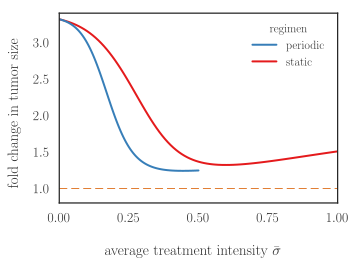

In [682]:
plt.rcParams['figure.figsize'] = (5, 3.5)

clr0 = sns.color_palette("Dark2",3)[1]
clrs1 = sns.color_palette("Set1",3)
clrs2 = sns.color_palette("Set1",2)

T = tmax # six months
ti = np.linspace(0,T,1e3+1)
σi = np.linspace(0.,1.,101)

szs = []
treatment_periodicity = 14
for σ in σi:
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.],0.)
    tme = 0; treatment = True
    while (tme+treatment_periodicity < T):
        tme += treatment_periodicity
        solver.set_f_params(int(treatment)*σ).integrate(tme)
        treatment = not treatment
    solver.set_f_params(int(treatment)*σ).integrate(T)
    szs = szs+[solver.y[1]]
plt.plot(.5*σi,szs,lw=lwd,ls="-",color=clrs1[1],label='periodic',zorder=2);

res = min(enumerate(szs), key=lambda p: p[1])
print("Best outcome for periodic treatment: sigma = %.2f, fold change = %.4f"%(.5*σi[res[0]],szs[res[0]]))

szs = []
for σ in σi:
    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.],0.).set_f_params(1.*σ).integrate(T)
    szs = szs+[solver.y[1]]
plt.plot(σi,szs,lw=lwd,ls="-",color=clrs1[0],label='static',zorder=-1);

xp = 10
print("Outcome for static particular treatment: sigma = %.2f, fold change = %.4f"%(σi[xp],szs[xp]))
print("Outcome for static MTD treatment: sigma = %.2f, fold change = %.4f"%(σi[len(σi)-1],szs[len(σi)-1]))

res = min(enumerate(szs), key=lambda p: p[1])
print("Best outcome for static treatment: sigma = %.2f, fold change = %.4f"%(σi[res[0]],szs[res[0]]))

plt.xlabel(r'average treatment intensity $\bar\sigma$',labelpad=20);
plt.ylabel('fold change in tumor size',labelpad=12);
plt.xlim([0,1]); 
plt.xticks(np.arange(0,1.25,.25));
plt.ylim([0.8,ymx]);
plt.margins(0.0);

legend = plt.legend(frameon=0,title='regimen',loc=1,fontsize=12); #,fontsize='small'
plt.setp(legend.get_title(),fontsize=12);

# This was obtained in solution of the optimal control problem #
plt.plot([0,1],[1]*2,lw=.8,color=clr0,ls="--",zorder=-4,dashes=(10,5)); 

plt.savefig("../figures/draft/Fig4-C.pdf",format='pdf',bbox_inches='tight')

In [586]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}

\begin{document}
\begin{tikzpicture}
    \node[anchor=north west] {\includegraphics[width=5.8in]{../figures/draft/Fig4-AB.pdf}};
    \node[anchor=north east] at (4.7in,-3.1in) {\includegraphics[width=3.1in]{../figures/draft/Fig4-C.pdf}};
    \node[anchor=south east] at (.1in,-.08in) {\large {\bf A}};
    \node[anchor=south west] at (3in,-.08in) {\large {\bf B}};
    \node[anchor=south west] at (1.45in,-3.18in) {\large {\bf C}};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/Fig4.pdf
rm texput.*

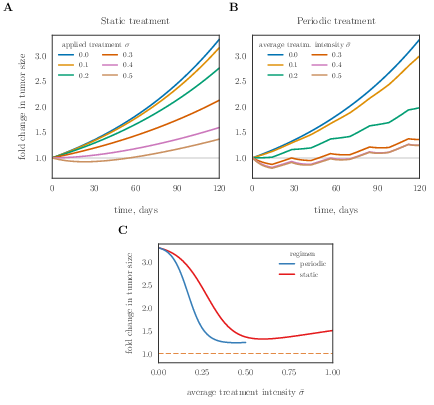

In [587]:
# Final result
WImage(filename='../figures/Fig4.pdf')

# Figure 5BCD

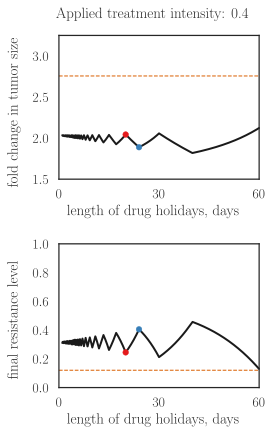

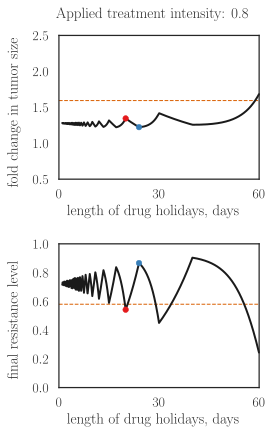

In [588]:
i = 0
prds = [20,24]
for σFixed in [.4,.8]:
    plt.rcParams['figure.figsize'] = (3.6, 6.5)
    plt.subplot(211)
    plt.subplots_adjust(hspace = 0.45)

    periods = np.arange(1,T/2,.05)
    szs = []; sgms_x = []; resistance_x = [];
    for treatment_periodicity in periods:
        solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
        tme = 0; treatment = True
        while (tme+treatment_periodicity < T):
            tme += treatment_periodicity
            solver.set_f_params(int(treatment)*σFixed).integrate(tme)
            treatment = not treatment
        solver.set_f_params(int(treatment)*σFixed).integrate(T)
        szs = szs+[solver.y[1]]

    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.]).set_f_params(.5*σFixed).integrate(T)
    sz_static = solver.y[1]
    plt.plot([0,max(periods)],[sz_static]*2,color=clr0,lw=1,ls='--',zorder=-1)
        
    for k in range(2):
        treatment_periodicity = prds[k]
        solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
        tme = 0; treatment = True
        while (tme+treatment_periodicity < T):
            tme += treatment_periodicity
            solver.set_f_params(int(treatment)*σFixed).integrate(tme)
            treatment = not treatment
        solver.set_f_params(int(treatment)*σFixed).integrate(T)
        plt.scatter([treatment_periodicity],[solver.y[1]],facecolor=clrs2[k],lw=.5,zorder=3,s=32)

    plt.plot(periods,szs,lw=lwd,ls="-",color="k");
    
    plt.title('Applied treatment intensity:  %.1f' % (σFixed), y=1.08)
    plt.xlabel('length of drug holidays, days');
    plt.ylabel('fold change in tumor size',labelpad=12);
    plt.xlim([0,max(periods)]); plt.ylim([.5,2.5] if i==1 else [1.5,3.25]); 
    plt.xticks(np.arange(0,T/2+30,30))
    plt.margins(0.0)
    
    plt.subplot(212)
    
    szs = []; sgms_x = []; resistance_x = [];
    for treatment_periodicity in periods:
        sgms_x = sgms_x+[σFixed]
        solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
        tme = 0; treatment = True
        while (tme+treatment_periodicity < T):
            tme += treatment_periodicity
            solver.set_f_params(int(treatment)*σFixed).integrate(tme)
            treatment = not treatment
        solver.set_f_params(int(treatment)*σFixed).integrate(T)
        szs = szs+[solver.y[1]]
        resistance_x = resistance_x+[solver.y[0]]

    solver = ode(ode_rhs).set_integrator(backend)
    solver.set_initial_value([ε,1.]).set_f_params(.5*σFixed).integrate(T)
    sz_constant = solver.y[1]
    resistance_constant = solver.y[0]
    plt.plot([0,max(periods)],[resistance_constant]*2,color=clr0,lw=1,zorder=-1,ls="--")
    
    for k in range(2):
        treatment_periodicity = prds[k]
        solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
        tme = 0; treatment = True
        while (tme+treatment_periodicity < T):
            tme += treatment_periodicity
            solver.set_f_params(int(treatment)*σFixed).integrate(tme)
            treatment = not treatment
        solver.set_f_params(int(treatment)*σFixed).integrate(T)
        plt.scatter([treatment_periodicity],[solver.y[0]],facecolor=clrs2[k],lw=.5,zorder=3,s=32)

    plt.plot(periods,resistance_x,lw=lwd,ls="-",color="k");

    plt.xlabel('length of drug holidays, days');
    plt.ylabel('final resistance level',labelpad=12);
    plt.xlim([0,max(periods)]); plt.ylim([0,1]); 
    plt.xticks(np.arange(0,T/2+30,30))
    plt.margins(0.0)
    
    plt.savefig("../figures/draft/Fig5-CD%d.pdf" % (i+1),format='pdf',bbox_inches='tight') 
    plt.show()

    i += 1

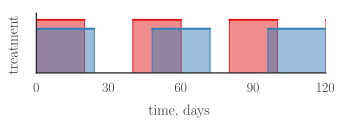

In [589]:
plt.rcParams['figure.figsize'] = (5.2, 1.1)
plt.subplots_adjust(hspace = 0.3)


k = 0; σFixed = .8; n = 3
for treatment_periodicity in [T/(2*n),T/(2*n-1)]:
    patches = []
    σx = σFixed*((2*n-1)/(2*n) if k==1 else 1)

    for i in range(n+1):
        plt.plot([2*i*treatment_periodicity,(2*i+1)*treatment_periodicity],[σx]*2,lw=lwd,color=clrs2[k],zorder=-3+2*k)
        for l in range(2):
            plt.plot([(2*i+l)*treatment_periodicity,(2*i+l)*treatment_periodicity],[σx,0],lw=.75,ls='-',
                     color=clrs2[k],zorder=-3+2*k)
        polygon = Polygon([(2*i*treatment_periodicity,0),(2*i*treatment_periodicity,σx),
                           ((2*i+1)*treatment_periodicity,σx),((2*i+1)*treatment_periodicity,0)], True)
        patches.append(polygon)
        
    p = PatchCollection(patches,alpha=.5,color=clrs2[k], zorder=-4+2*k);
    plt.gca().add_collection(p)
    
    k += 1

plt.xlim([0,T]); plt.ylim([0,.9])
xtks = np.arange(0,T+30,30); plt.xticks(xtks,[x if k else "" for x in xtks])
plt.ylabel('treatment',labelpad=16);
plt.xlabel('time, days',labelpad=10);
ytks = [0,σx,σFixed]; plt.yticks([]);
sns.despine(offset=0)
plt.margins(0.0)

plt.savefig("../figures/draft/Fig5-B.pdf",format='pdf',bbox_inches='tight')

# Periodic treatment

## Generating data for Figure S4
** ¡It takes quite a substantial amount of time! **

In [590]:
# Change to True if you need recalculation
recalc3 = True

In [591]:
def func_σ(treatment_periodicity,σx,out):
    solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
    tme = 0; treatment = True
    if out: print(σx)
    while (tme+treatment_periodicity < T):
        tme += treatment_periodicity
        solver.set_f_params(int(treatment)*σx).integrate(tme)
        treatment = not treatment
    solver.set_f_params(int(treatment)*σx).integrate(T)
    return solver.y

Difference:

In [592]:
step_periods = 1; step_σFixed = .01
Periods, σFixed = np.meshgrid(np.arange(1,T/2+step_periods,step_periods),np.arange(0,1.+step_σFixed,step_σFixed))
periods_n, σFixed_n = Periods.shape

from pathlib import Path
datafile = '../figures/draft/FigS4.pkl'

if (recalc3|(not Path(datafile).is_file())):
    time0=time.time()
    
    Resistance = Periods*0
    FoldChange = Periods*0
    for xk in range(periods_n):
        for yk in range(σFixed_n):
            Resistance[xk,yk], FoldChange[xk,yk] = func_σ(Periods[xk,yk],σFixed[xk,yk],False)

    print("This proccess took %0.1f minutes" % ((time.time()-time0)/60.))
    
    # Saving the data
    file_to_write = open(datafile,'wb')
    pickle.dump([Resistance, FoldChange], file_to_write)
    file_to_write.close()
    
    recalc3 = False
else:
    # Loading the data
    file_to_load = open(datafile,'rb')
    Resistance, FoldChange = pickle.load(file_to_load)
    file_to_load.close()

This proccess took 2.3 minutes


## Captions AB

Best outcome: period = 24.00, sigma = 0.82, fold change = 1.2232
Nearest point: period = 23.00, sigma = 0.83, fold change = 1.2507


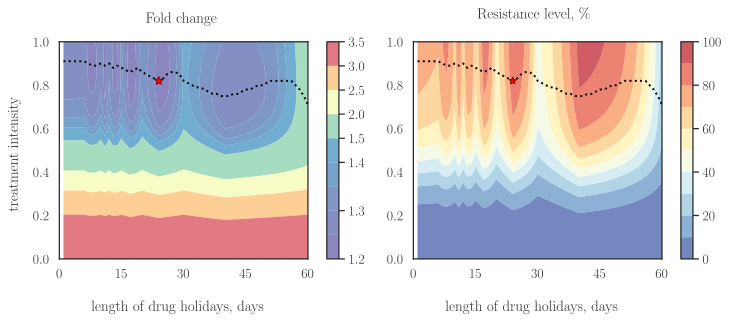

In [593]:
xmx = T/2
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(121)
plt.subplots_adjust(wspace = 0.125)
        
plt.rcParams['figure.figsize'] = (8, 5)
plt.contourf(Periods,σFixed,FoldChange,cmap="Spectral_r",zorder=-2,alpha=.7,
            levels=[1.2,1.25,1.3,1.35,1.4,1.5,2,2.5,3,3.5])
cbar = plt.colorbar(pad=.06,aspect=18)
plt.xticks(np.arange(0,xmx+15,15));

sz=20; zmax = 6.

tks = [1,1.1,1.2,1.3,1.4,1.5,2,2.5,3,3.5]
cbar.set_ticks(tks)
        
pts_x = []; pts_y = []; pts_z = []
for n in range(len(Periods[1,:])):
    res = min(enumerate(FoldChange[:,n]), key=lambda p: p[1])
    pts_x = np.append(pts_x,Periods[1,n])
    pts_y = np.append(pts_y,σFixed[res[0],n])
    pts_z = np.append(pts_z,res[1])
    
res = min(enumerate(pts_z), key=lambda p: p[1])
plt.scatter([pts_x[res[0]]],[pts_y[res[0]]],facecolor="red",marker=(5,1),s=80,linewidth=.5,color="black",zorder=4);
print("Best outcome: period = %.2f, sigma = %.2f, fold change = %.4f"%(pts_x[res[0]],pts_y[res[0]],pts_z[res[0]]))
print("Nearest point: period = %.2f, sigma = %.2f, fold change = %.4f"%(pts_x[res[0]-1],pts_y[res[0]-1],pts_z[res[0]-1]))

plt.plot(pts_x,pts_y,lw=lwd,ls=":",color="black",zorder=3);

plt.xlabel('length of drug holidays, days',labelpad=20);
plt.ylabel('treatment intensity',labelpad=12);
plt.yticks(np.arange(0,1.2,.2))
plt.xlim([0,xmx]); plt.ylim([0,1])

plt.title(r'Fold change', y=1.06)

plt.subplot(122)

plt.contourf(Periods,σFixed,Resistance,cmap="RdYlBu_r",
             levels=np.arange(0,1.1,.1),zorder=-2,alpha=.7)

cbar = plt.colorbar(pad=.06,aspect=18)
cbar.set_ticks(np.arange(0,1.2,.2))
cbar.set_ticklabels([int(x*100) for x in np.arange(0,1.2,.2)])

plt.title('Resistance level, \%', y=1.08)

plt.scatter([pts_x[res[0]]],[pts_y[res[0]]],facecolor="red",marker=(5,1),
            s=60,lw=.5,color="black",zorder=4);
plt.plot(pts_x,pts_y,lw=lwd,ls=":",color="black",zorder=3);

plt.xlabel('length of drug holidays, days',labelpad=20);
plt.xticks(np.arange(0,xmx+15,15))
plt.yticks(np.arange(0,1.2,.2))
plt.xlim([0,xmx]); plt.ylim([0,1])

plt.savefig("../figures/draft/FigS4-AB.pdf",format='pdf',bbox_inches='tight')

## Caption C

Optimal treatment: period = 24.00, intensity = 0.82, fold change = 1.2232


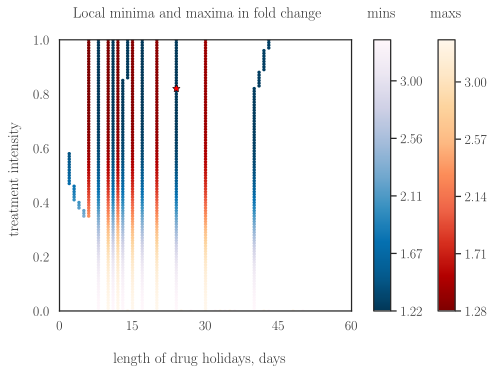

In [594]:
###### plt.rcParams['figure.figsize'] = (7, 4)
lw1 = .0

maximas = lambda a: np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]

σ_mxms = []; σ_mnms = [];
prds_mxms = []; prds_mnms = [];
fold_mxms = []; fold_mnms = [];
cut_factor_mn = 3; cut_factor_mx = 3; sz = 12
for n in range(len(σFixed[:,1])):
    σ = σFixed[n,1]
    # Maxima
    mxms = argrelextrema(FoldChange[n,:],np.greater)[0]
    # Minima
    mnms = argrelextrema(FoldChange[n,:],np.less)[0]
    if len(mxms):
        σ_mxms = σ_mxms+[σ for x in range(len(mxms))]
        prds_mxms = np.append(prds_mxms,Periods[n,mxms])
        fold_mxms = np.append(fold_mxms,FoldChange[n,mxms])
    if len(mnms):
        σ_mnms = σ_mnms+[σ for x in range(len(mnms))]
        prds_mnms = np.append(prds_mnms,Periods[n,mnms])
        fold_mnms = np.append(fold_mnms,FoldChange[n,mnms])
        
plt.scatter(prds_mxms,σ_mxms,c=[x/cut_factor_mx for x in fold_mxms],\
            cmap="OrRd_r",s=sz,zorder=-2,linewidth=lw1);
cbar1 = plt.colorbar(pad=.02,aspect=16)
tks = np.linspace(min(fold_mxms/cut_factor_mx),1,5)
cbar1.set_ticks(tks)
cbar1.ax.set_title("maxs", y=1.06)
cbar1.set_ticklabels(["%.2f"%(cut_factor_mx*x) for x in tks])

plt.scatter(prds_mnms,σ_mnms,c=[x/cut_factor_mn for x in fold_mnms],\
            cmap="PuBu_r",s=sz,zorder=-1,linewidth=lw1);
cbar2 = plt.colorbar(pad=.06,aspect=16)
tks = np.linspace(min(fold_mnms/cut_factor_mn),1,5)
cbar2.ax.set_title("mins", y=1.06)
cbar2.set_ticks(tks)
cbar2.set_ticklabels(["%.2f"%(cut_factor_mn*x) for x in tks])

print("Optimal treatment: period = %.2f, intensity = %.2f, fold change = %.4f"%(pts_x[res[0]],pts_y[res[0]], pts_z[res[0]]))

plt.scatter([pts_x[res[0]]],[pts_y[res[0]]],facecolor="red",marker=(5,1),
            s=60,lw=.5,color="black",zorder=4);

plt.xlim([0,max(Periods[1,:])]); plt.ylim([0,1]);
plt.xticks(np.arange(0,T/2+15,15))
plt.yticks(np.arange(0,1.2,.2))

plt.xlabel('length of drug holidays, days',labelpad=20);
plt.ylabel('treatment intensity',labelpad=12);
plt.title('Local minima and maxima in fold change', y=1.06)

plt.savefig("../figures/draft/FigS4-C.pdf",format='pdf',bbox_inches='tight')

## Caption D

2


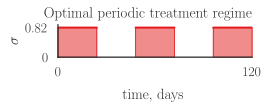

In [595]:
plt.rcParams['figure.figsize'] = (3.5, .6)

k = 0; σFixed = pts_y[res[0]]; treatment_periodicity = pts_x[res[0]]; 
n = int(T/2/treatment_periodicity)

print(n)

σ_x = σFixed
patches = []

for i in range(n+1):
    plt.plot([2*i*treatment_periodicity,(2*i+1)*treatment_periodicity],[σ_x]*2,lw=lwd,color=clrs2[0])
    for l in range(2):
        plt.plot([(2*i+l)*treatment_periodicity,(2*i+l)*treatment_periodicity],[σ_x,0],lw=.75,ls='-',color=clrs2[k],zorder=-3+2*k)
    polygon = Polygon([(2*i*treatment_periodicity,0),(2*i*treatment_periodicity,σ_x),((2*i+1)*treatment_periodicity,σ_x),((2*i+1)*treatment_periodicity,0)], True)
    patches.append(polygon)

p = PatchCollection(patches,alpha=.5,color=clrs1[0]);
plt.gca().add_collection(p)

plt.xlim([0,T]); plt.ylim([0,.9])
xtks = np.arange(0,T+120,120); plt.xticks(xtks)
plt.xlabel('time, days',labelpad=10);
plt.ylabel(r'$\sigma$',labelpad=4);
ytks = [0,σ_x]; plt.yticks(ytks,[0,round(σ_x,3)]);
plt.title('Optimal periodic treatment regime', y=1.04)
sns.despine(offset=0)

plt.savefig("../figures/draft/FigS4-D.pdf",format='pdf',bbox_inches='tight')

## Generating Figure S4 using tikz/TeX

In [600]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}
 
\begin{document}
\begin{tikzpicture}
    \node[anchor=south] {\includegraphics[width=6.2in]{../figures/draft/FigS4-AB.pdf}};
    \node[anchor=north east] at (0.67in,0) {\includegraphics[width=3.7in]{../figures/draft/FigS4-C.pdf}};
    \node[anchor=north west] at (.55in,-.65in) {\includegraphics[width=2.1in]{../figures/draft/FigS4-D.pdf}};
    \node[anchor=south east] at (-2.93in,2.66in) {\large {\bf A}};
    \node[anchor=south east] at (.25in,2.66in) {\large {\bf B}};
    \node[anchor=south east] at (-2.93in,-.11in) {\large {\bf C}};
    \node[anchor=south east] at (.8in,-.78in) {\large {\bf D}};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/FigS4.pdf
rm texput.*

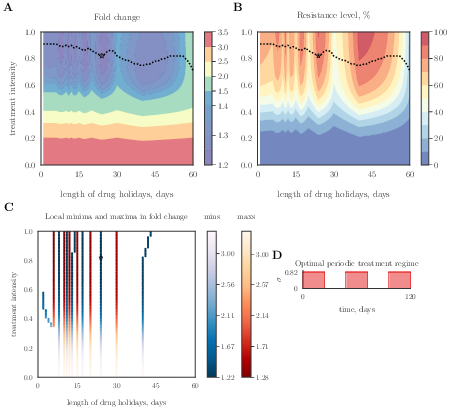

In [601]:
# Final result
WImage(filename='../figures/FigS4.pdf')

## Generating data for Figure S5
** ¡It takes quite a substantial amount of time! **

In [614]:
# Change to True if you need recalculation
recalc2 = True

In [615]:
def funcX(treatment_cycle,x,σ_x):
    solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
    tme = 0
    while (tme+cycle < T):
        tme += treatment_cycle*(1+x)/2
        solver.set_f_params(σ_x).integrate(tme)
        tme += treatment_cycle*(1-x)/2
        solver.set_f_params(0.).integrate(tme)
    if (tme+cycle*(1+x)/2 < T):
        tme += treatment_cycle*(1+x)/2
        solver.set_f_params(σ_x).integrate(tme)
        solver.set_f_params(0.).integrate(T)
    else:
        solver.set_f_params(σ_x).integrate(T)
    return solver.y

In [617]:
##########
cycle = 8
##########

step_x = .01; step_σ = .01
Xs, σs = np.meshgrid(np.arange(-1.,1.+step_x,step_x),np.arange(0,1.+step_σ,step_σ))
x_n, σ_n = Xs.shape

from pathlib import Path
datafile2 = "../figures/draft/FigS5.pkl"

if (recalc2|(not Path(datafile2).is_file())):
    time0=time.time()
    
    FoldChangeX = Xs*0
    ResistanceX = Xs*0
    TreatmentX = Xs*0
    for xk in range(x_n):
        for yk in range(σ_n):
            ResistanceX[xk,yk], FoldChangeX[xk,yk] = funcX(cycle,Xs[xk,yk],σs[xk,yk])
            TreatmentX[xk,yk] = σs[xk,yk]

    print("This proccess took %0.1f minutes" % ((time.time()-time0)/60.))
    
    # Saving the data
    file_to_save = open(datafile2,'wb')
    pickle.dump([TreatmentX, ResistanceX, FoldChangeX], file_to_save)
    file_to_save.close()
    
    recalc2 = False
else:
    # Loading the data
    file_to_load = open(datafile2,'rb')
    TreatmentX, ResistanceX, FoldChangeX = pickle.load(file_to_load)
    file_to_load.close()

This proccess took 7.3 minutes


## Captions AB

Best outcome: ψ = 0.62, σ = 0.80, fold change = 1.262


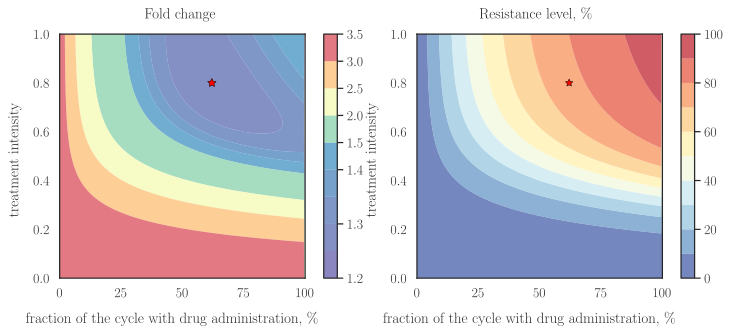

In [669]:
plt.rcParams['figure.figsize'] = (12, 4.5)
plt.subplot(121)
plt.subplots_adjust(hspace = 0.3, wspace = .15)

xlb = 'fraction of the cycle with drug administration, \%'

cut_factor = 3
        
pts_x = []; pts_y = []; pts_z = []
for n in range(1,len(Xs[1,:])-1): #the first and the last elements are removed
    res = min(enumerate(FoldChangeX[:,n]), key=lambda p: p[1])
    pts_x = np.append(pts_x,Xs[1,n])
    pts_y = np.append(pts_y,σs[res[0],n])
    pts_z = np.append(pts_z,res[1])
    
res = min(enumerate(pts_z), key=lambda p: p[1])
plt.scatter([pts_x[res[0]]],[pts_y[res[0]]],facecolor="red",marker=(5,1),s=80,linewidth=.5,color="black",zorder=4);
print("Best outcome: ψ = %.2f, σ = %.2f, fold change = %.3f" % ((1+pts_x[res[0]])/2,pts_y[res[0]],pts_z[res[0]]))
        
plt.contourf(Xs,σs,FoldChangeX,cmap="Spectral_r",zorder=-2,alpha=.7,
            levels=[1.2,1.25,1.3,1.35,1.4,1.5,2,2.5,3,3.5])
cbar = plt.colorbar(pad=.06,aspect=18)
xtks = np.arange(-1,1.5,.5)
plt.xticks(xtks,["%d" % int(100*(x+1)/2) for x in xtks]) 
plt.xlim([-1,1]); plt.ylim([0,1])


tks = [1,1.1,1.2,1.3,1.4,1.5,2,2.5,3,3.5]
cbar.set_ticks(tks)

plt.title('Fold change', y=1.04)

plt.ylabel('treatment intensity',labelpad=12);
plt.yticks(np.arange(0,1.2,.2))

plt.xlabel(xlb,labelpad=12);

plt.subplot(122)

plt.scatter([pts_x[res[0]]],[pts_y[res[0]]],facecolor="red",marker=(5,1),
            s=60,lw=.5,color="black",zorder=4);
# plt.plot(pts_x,pts_y,lw=lwd,ls=":",color="black",zorder=3);

plt.contourf(Xs,σs,ResistanceX,cmap="RdYlBu_r",levels=np.arange(0,1.1,.1),zorder=-2,alpha=.7)

plt.title('Resistance level, \%', y=1.04)

cbar = plt.colorbar(pad=.06,aspect=18)
cbar.set_ticks(np.arange(0,1.2,.2))
cbar.set_ticklabels([int(x*100) for x in np.arange(0,1.2,.2)])

plt.xlabel(xlb,labelpad=12);
plt.ylabel('treatment intensity',labelpad=12);
plt.xticks(xtks,["%d" % int(100*(x+1)/2) for x in xtks])
plt.yticks(np.arange(0,1.2,.2))
plt.xlim([-1,1]); plt.ylim([0,1])

plt.savefig("../figures/draft/FigS5-AB.pdf",format='pdf',bbox_inches='tight')

## Caption C

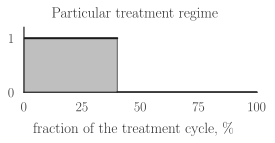

In [670]:
plt.rcParams['figure.figsize'] = (4.2, 1.2)

x0 = -0.2
plt.plot([0,(1+x0)/2],[1,1],lw=lwd,color="k")
plt.plot([(1+x0)/2,1],[0,0],lw=lwd,color="k")
plt.plot([(1+x0)/2,(1+x0)/2],[1,0],lw=.75,color="k",ls='-',zorder=-3)
p = PatchCollection([Polygon([(0,0),(0,1),((1+x0)/2,1),((1+x0)/2,0)], True)],alpha=.5,color="grey");
plt.gca().add_collection(p)

xtks = np.arange(0,1.25,.25)
plt.xlim([0,1]); plt.ylim([0,1.2])
plt.xticks(xtks,["%d" % int(100*x) for x in xtks])
plt.title('Particular treatment regime',y=1.06);
plt.xlabel('fraction of the treatment cycle, \%',labelpad=8);

#plt.yticks([0,1],[0,r'$\sigma=\min\left(\frac{2\bar\sigma}{1+\psi},1\right)$']);
sns.despine(offset=0)

plt.savefig("../figures/draft/FigS5-C.pdf",format='pdf',bbox_inches='tight')

## Generating Figure S5 using tikz/TeX

In [671]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}
 
\begin{document}
\begin{tikzpicture}
    \node[anchor=north west] {\includegraphics[width=\textwidth]{../figures/draft/FigS5-AB.pdf}};
    \node[anchor=north west] at (.25in,-2.32in) {\includegraphics[width=.36\textwidth]{../figures/draft/FigS5-C.pdf}};
    \node[anchor=south east] at (.15in,-.1in) {\large {\bf A}};
    \node[anchor=south east] at (2.55in,-.1in) {\large {\bf B}};
    \node[anchor=south east] at (.25in,-2.42in) {\large {\bf C}};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/FigS5.pdf
rm texput.*

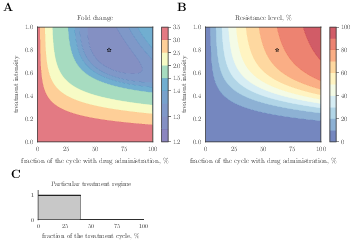

In [672]:
# Final result
WImage(filename='../figures/FigS5.pdf')

# Figure 4: Comparing particular treatments
We generate only output for two treatment and we will use it later in another R-notebook.

In [425]:
def funcXtrj(treatment_cycle,x,σ,nsteps=10):
    σ_x = 2*σ/(1.+max([2*σ-1,x]))
    solver = ode(ode_rhs).set_integrator(backend).set_initial_value([ε,1.])
    sol = [[0.,σ_x,ε,1.]]; tme = 0
    while (tme+treatment_cycle < T):
        デルタ = treatment_cycle*(1+x)/2
        ti = np.linspace(tme,tme+デルタ,nsteps)
        _k = 0
        while (solver.t < max(ti)):
            solver.set_f_params(σ_x).integrate(ti[_k])
            if _k:
                sol.append([solver.t,σ_x]+list(solver.y))
            _k += 1
        tme += デルタ
        デルタ = treatment_cycle*(1-x)/2
        ti = np.linspace(tme,tme+デルタ,nsteps)
        _k = 0
        while (solver.t < max(ti)):
            solver.set_f_params(0.0).integrate(ti[_k])
            if _k:
                sol.append([solver.t,0.0]+list(solver.y))
            _k += 1
        tme += デルタ
    if (tme+treatment_cycle*(1+x)/2 < T):
        デルタ = treatment_cycle*(1+x)/2
        ti = np.linspace(tme,tme+デルタ,nsteps,endpoint=False)
        _k = 0
        while (solver.t < max(ti)):
            solver.set_f_params(σ_x).integrate(ti[_k])
            if _k:
                sol.append([solver.t,σ_x]+list(solver.y))
            _k += 1
        tme += デルタ
        ti = np.linspace(tme,T,nsteps,endpoint=True)
        _k = 0
        while (solver.t < max(ti)):
            solver.set_f_params(0.0).integrate(ti[_k])
            if _k:
                sol.append([solver.t,0.0]+list(solver.y))
            _k += 1
    else:
        ti = np.linspace(tme,T,nsteps,endpoint=True)
        _k = 0
        while (solver.t < max(ti)):
            solver.set_f_params(σ_x).integrate(ti[_k])
            if _k:
                sol.append([solver.t,σ_x]+list(solver.y))
            _k += 1
    return sol

In [426]:
pd.DataFrame(funcXtrj(32,0,.8,50)).to_csv('../figures/draft/Fig4-trj_periodic.csv',index=False,header=False)
pd.DataFrame(funcXtrj(32,1,.52,50)).to_csv('../figures/draft/Fig4-trj_const.csv',index=False,header=False)

# Figure 6
Figures 6A, 6B and 6C are obtained in the notebook "**C1. Sensitivity analysis.ipynb**". Then the figure was assembled in external program Adobe Illustrator (licence of Hokkaido University).

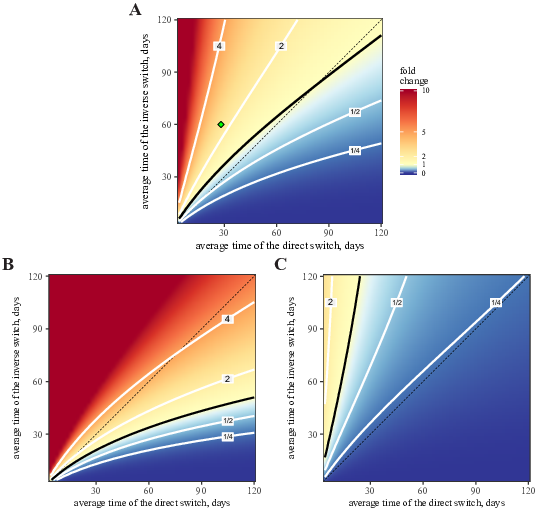

In [234]:
# Final version
WImage(filename='../figures/Fig6.pdf')

# Appendix Figure 2

It was obtained in the notebook "**D. Field of optimal trajectories.ipynb**". Here we modify it a bit using tikz/LaTeX

In [ ]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}
 
\begin{document}
\begin{tikzpicture}
    \node {\includegraphics[scale=.85]{../figures/draft/AppendixFig2.pdf}};
    \node at (-.79in,1in) {\scalebox{1.2}{$\mathcal S_1$}};
    \node at (1.2in,.9in) {\scalebox{1.2}{$\mathcal S_2$}};
    \node at (-1.42in,1.07in) {$\bar x_2$};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/AppendixFig2.pdf
rm texput.*

In [ ]:
# Final version
WImage(filename='../figures/AppendixFig2.pdf')

# Appendix Fig 1

The constituent parts were obtained in the notebook "**D. Field of optimal trajectories.ipynb**"

In [ ]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}
 
\begin{document}
\begin{tikzpicture}
    \node[anchor=south east] at (0,.1in) {\includegraphics[width=2.5in]{../figures/draft/AppendixFig1-A.pdf}};
    \node[anchor=south west] at (.25in,.1in) {\includegraphics[width=2.5in]{../figures/draft/AppendixFig1-B.pdf}};
    \node[anchor=north east] {\includegraphics[width=2.5in]{../figures/draft/AppendixFig1-C.pdf}};
    \node[anchor=north west] at (.25in,0) {\includegraphics[width=2.5in]{../figures/draft/AppendixFig1-D.pdf}};
    \node[anchor=south east] at (-2.5in,1.9in) {\large {\bf A}};
    \node[anchor=south west] at (.15in,1.9in) {\large {\bf B}};
    \node[anchor=south east] at (-2.5in,-.05in) {\large {\bf C}};
    \node[anchor=south west] at (.15in,-.05in) {\large {\bf D}};
    \node[anchor=south east] at (-.36in,-2.05in) {treatment intensity $\sigma$};
    \node[anchor=south east] at (2.51in,-2.05in) {treatment intensity $\sigma$};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/AppendixFig1.pdf
rm texput.*

In [ ]:
# Final version
WImage(filename='../figures/AppendixFig1.pdf')

# Figure 4

It was obtained in the notebook "**E. Figures 4 and 5.ipynb**"

In [ ]:
%%capture
%%bash
pdflatex <<TeXScript
\documentclass{standalone}
\usepackage{tikz,graphicx}
\usepackage[T1]{fontenc}
 
\begin{document}
\begin{tikzpicture}
    \node[anchor=south] {\includegraphics[scale=1]{../figures/draft/Fig4.pdf}};
    \node[anchor=north] at (.02in,.6in) {\(T_0\)};
    \node[anchor=north] at (.57in,.6in) {\(T_{-}\)};
    \node[anchor=north] at (-1.45in,.6in) {\(T_{+}\)};
    \node[anchor=north] at (.68in,1.7in) {(\emph{i})};
    \node[anchor=north] at (-1.35in,1.7in) {(\emph{ii})};
    \node[anchor=north] at (-1.3in,2.42in) {(\emph{iii})};
    \node[anchor=north] at (-.12in,2.47in) {dose-sparing regimen};
\end{tikzpicture}
\end{document}
TeXScript
mv texput.pdf ../figures/Fig4.pdf
rm texput.*

In [ ]:
# Final version
WImage(filename='../figures/Fig4.pdf')

# Figure 5

It was obtained in the notebook "**E. Figures 4 and 5.ipynb**". Then the figure was assembled in external program Adobe Illustrator (licence of Hokkaido University).

In [ ]:
# Final version
WImage(filename='../figures/Fig5.pdf')